- Plot Sentinel-2 RGB images (2023) for all Climate TRACE TOP 20 landfills
- Plot monthly Sentinel-2 images for the Ghabawi and Ghazipur landfills

In [1]:
import os
import pandas as pd
from pystac_client import Client
from odc.stac import load
from shapely import Point
import xarray as xr
import pyproj
from glob import glob
import calendar
import matplotlib.pyplot as plt

In [2]:
from matplotlib import rcParams
font_size = 15
rcParams['axes.titlesize'] = font_size - 3
# rcParams['axes.titleweight'] = 'bold'
# rcParams['axes.labelsize'] = font_size - 2
# rcParams['xtick.labelsize'] = font_size - 2
# rcParams['ytick.labelsize'] = font_size - 2
# rcParams['legend.fontsize'] = font_size
rcParams['figure.titlesize'] = font_size 
rcParams['figure.titleweight'] = 'bold'

## Read data

In [3]:
df = pd.read_excel('../data/landfills_hyper_obs.xlsx', sheet_name='ClimateTrace_TOP20')

df['plume_mask'] = df[['plume(emit)', 'plume(enmap)', 'plume(prisma)']].sum(axis=1) > 0

obs_mask = ~(df[['overpass(emit)', 'overpass(enmap)', 'overpass(prisma)']].sum(axis=1) == 0)

# tropomi hotspots with no plume detected by HSI
df['no_plume_mask'] = (df[['plume(emit)', 'plume(enmap)', 'plume(prisma)']].sum(axis=1) == 0) & obs_mask

## Download S2 images for TOP 20 landfills

In [4]:
# def get_bbox(row, buffer=0.01):
#     if 'longitude' in row.index:
#         point = Point(row['longitude'], row['latitude'])
#         # add the required distance/buffer around the lat lon
#         bbox = point.buffer(buffer).bounds
#     elif 'lon_min' in row.index:
#         bbox = (row['lon_min'], row['lat_min'], row['lon_max'], row['lat_max'])
#     else:
#         raise ValueError('Please make sure you have correct column names')

#     return bbox

# client = Client.open("https://earth-search.aws.element84.com/v1")
# collection = "sentinel-2-l2a"

# def get_img(row, datetime_range='2023-01-01/2023-12-31'):
#     # get one clear image in 2023
#     search = client.search(collections = [collection],
#                             bbox = row['bbox'],
#                             datetime = datetime_range,
#                             query = {"eo:cloud_cover":{"lt":0.03}},
#                             max_items=1,
#                             )
#     data = load(search.items(), bbox=row['bbox'], groupby="solar_day", chunks={})
#     savename = os.path.join('../data/S2_RGB/', row['name'].replace(' ', '_'))+'.nc'
#     print(f'Exporting to {savename}')
#     data[["red", "green", "blue"]].isel(time=0).to_array().rename('rgb').to_netcdf(savename)

# buffer = 0.01
# df['bbox'] = df.apply(get_bbox, buffer=buffer, axis=1)

# df.apply(get_img, axis=1)

## Plot S2 images

../data/S2_RGB/Bandeirantes.nc
../data/S2_RGB/Bisasar.nc
../data/S2_RGB/Chiconautla.nc
../data/S2_RGB/Fyli.nc
../data/S2_RGB/Ghabawi.nc
../data/S2_RGB/Grupo_Contadero_S.A._De_C.V..nc


/Users/xinz/miniconda3/envs/hyperch4/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/xinz/miniconda3/envs/hyperch4/lib/python3.11/site-packages/pyproj/transformer.py:820: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return self._transformer._transform_point(
/Users/xinz/miniconda3/envs/hyperch4/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/s

../data/S2_RGB/Komurcuoda.nc
../data/S2_RGB/Legajny.nc
../data/S2_RGB/Loma_Los_Colorados.nc
../data/S2_RGB/Los_Laureles.nc
../data/S2_RGB/Naameh.nc
../data/S2_RGB/Odayeri.nc
../data/S2_RGB/Relleno_Sanitario.nc
../data/S2_RGB/Relleno_Sanitario_Portezuelos.nc
../data/S2_RGB/Relleno_Sanitario_Puebla.nc
../data/S2_RGB/Simeprodeso.nc
../data/S2_RGB/Sudokwon.nc
../data/S2_RGB/Tehran.nc
../data/S2_RGB/West_New_Territories.nc
../data/S2_RGB/Xingfeng.nc


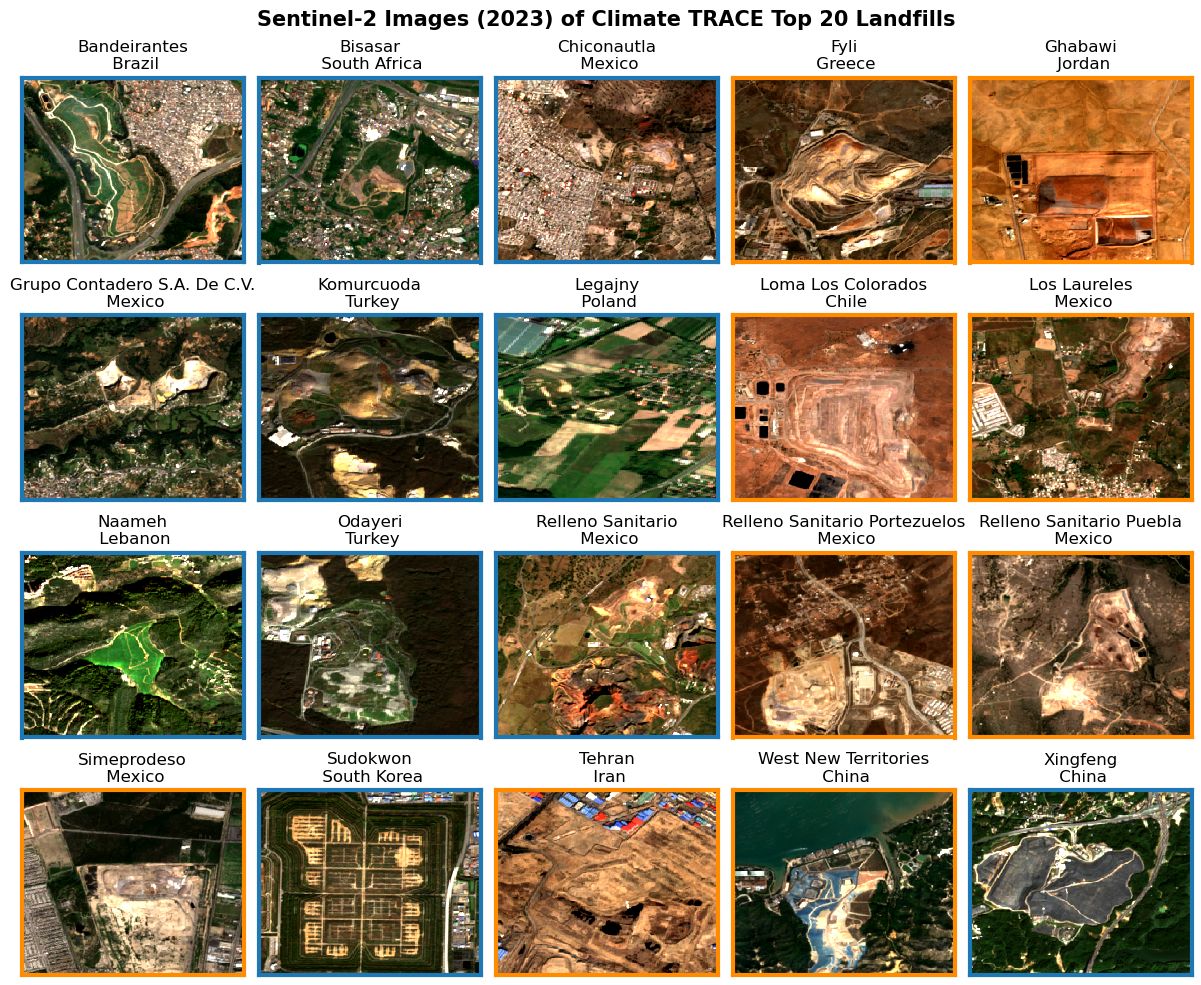

In [5]:
filenames = sorted(glob('../data/S2_RGB/*nc'))

fig, axs = plt.subplots(nrows=4, ncols=5, figsize=(12, 10))

axs = axs.flatten()

for index, filename_rgb in enumerate(filenames):
    name = os.path.basename(filename_rgb.split('.nc')[0].replace('_', ' '))
    print(filename_rgb)

    ds = xr.open_dataset(filename_rgb)
    ax = axs[index]
    ds['rgb'].plot.imshow(ax=ax, robust=True, rasterized=True)
    data_proj = pyproj.Proj(ds.rio.crs.to_proj4())
    row = df[df['name']==name]
    x, y = data_proj(row['longitude'], row['latitude'])
    # ax.scatter(x, y, marker='*', s=500, facecolors='none', edgecolors='w', linewidths=2)
    ax.set_title(name+f"\n {row['country'].item()}")
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    if row['plume_mask'].values:
        spine_color = 'darkorange'
    elif row['no_plume_mask'].values:
        spine_color = 'C0'
    else:
        spine_color = 'darkgray'

    for pos in ['top', 'bottom', 'right', 'left']:
            ax.spines[pos].set_edgecolor(spine_color)
            ax.spines[pos].set(lw=3)

plt.suptitle('Sentinel-2 Images (2023) of Climate TRACE Top 20 Landfills')

fig.tight_layout()
fig.savefig('../figures/s2_landfill.pdf')

## Download S2 image for two landfills

In [6]:
# def get_img_monthly(lon, lat, buffer, name, datetime_range='2023-01-01/2023-12-31', cloud_cover=1):
#     point = Point(lon, lat)
#     # add the required distance/buffer around the lat lon
#     bbox = point.buffer(buffer).bounds

#     client = Client.open("https://earth-search.aws.element84.com/v1")
#     collection = "sentinel-2-l2a"

#     search = client.search(collections = [collection],
#                             bbox = bbox,
#                             datetime = '2023-01-01/2023-12-31',
#                             query = {"eo:cloud_cover":{"lt":cloud_cover}},
#                             # max_items=1,
#                             )
#     data = load(search.items(), bbox=bbox, groupby="solar_day", chunks={})
#     savename = os.path.join('../data/S2_RGB/monthly/', name)+'.nc'
#     print(f'Exporting to {savename}')
#     data[["red", "green", "blue"]].groupby('time.month').first().to_array().rename('rgb').to_netcdf(savename)  

In [7]:
# get_img_monthly(lon=36.1871, lat=31.928748, buffer=0.01, name='Ghabawi')
# get_img_monthly(lon=77.3274, lat=28.6245, buffer=0.005, name='Ghazipur')

## Plot S2 images

In [8]:
rgb_Ghabawi = xr.open_dataset('../data/S2_RGB/monthly/Ghabawi.nc')
rgb_Ghazipur = xr.open_dataset('../data/S2_RGB/monthly/Ghazipur.nc')

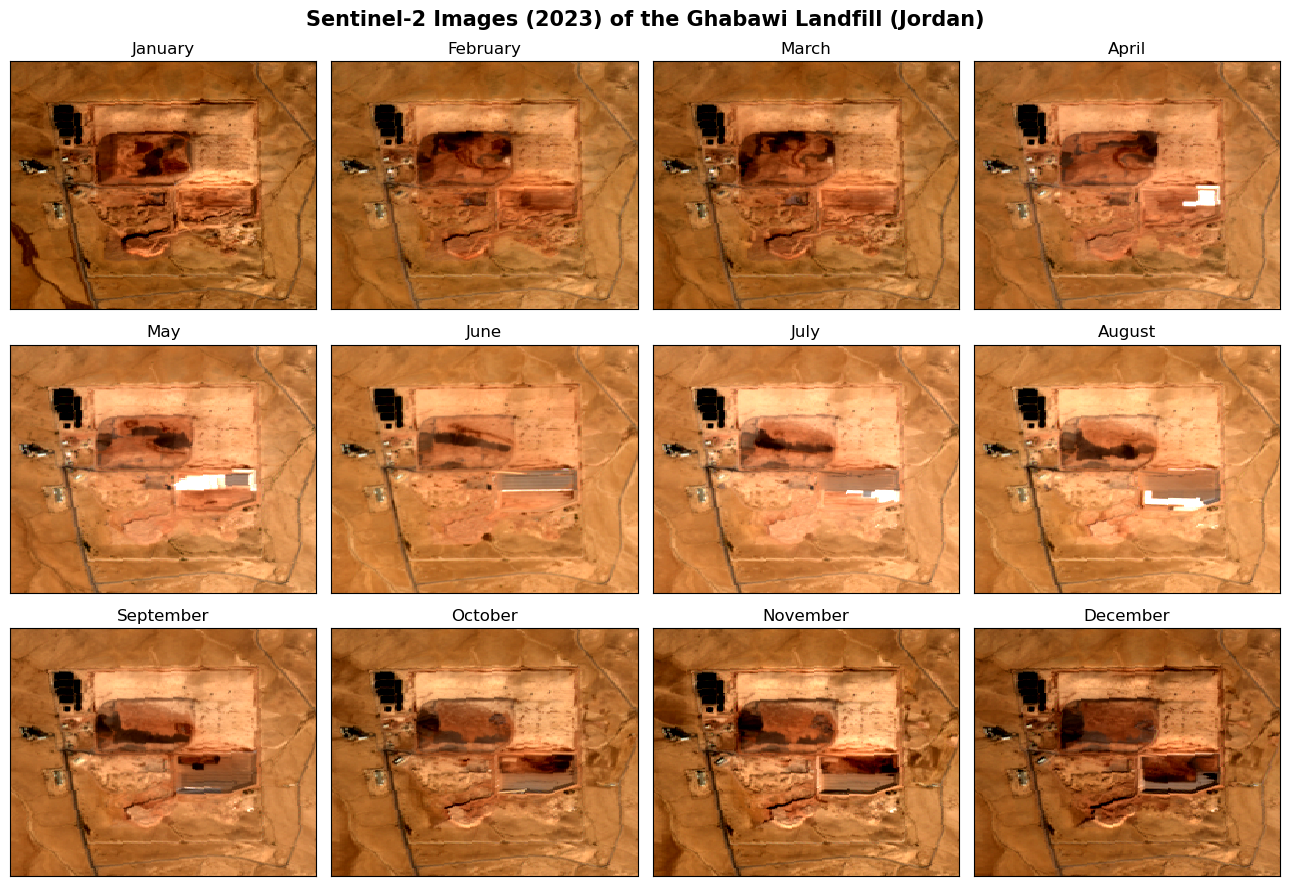

In [9]:
g = rgb_Ghabawi['rgb'].plot.imshow(x="x", y="y", col="month", col_wrap=4, robust=True, rasterized=True)

for i, ax in enumerate(g.axs.flat):
    ax.set_title(calendar.month_name[rgb_Ghabawi['rgb'].month[i].item()])
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

plt.suptitle('Sentinel-2 Images (2023) of the Ghabawi Landfill (Jordan)')
plt.tight_layout()
plt.savefig('../figures/S2_tseries_Ghabawi.pdf')

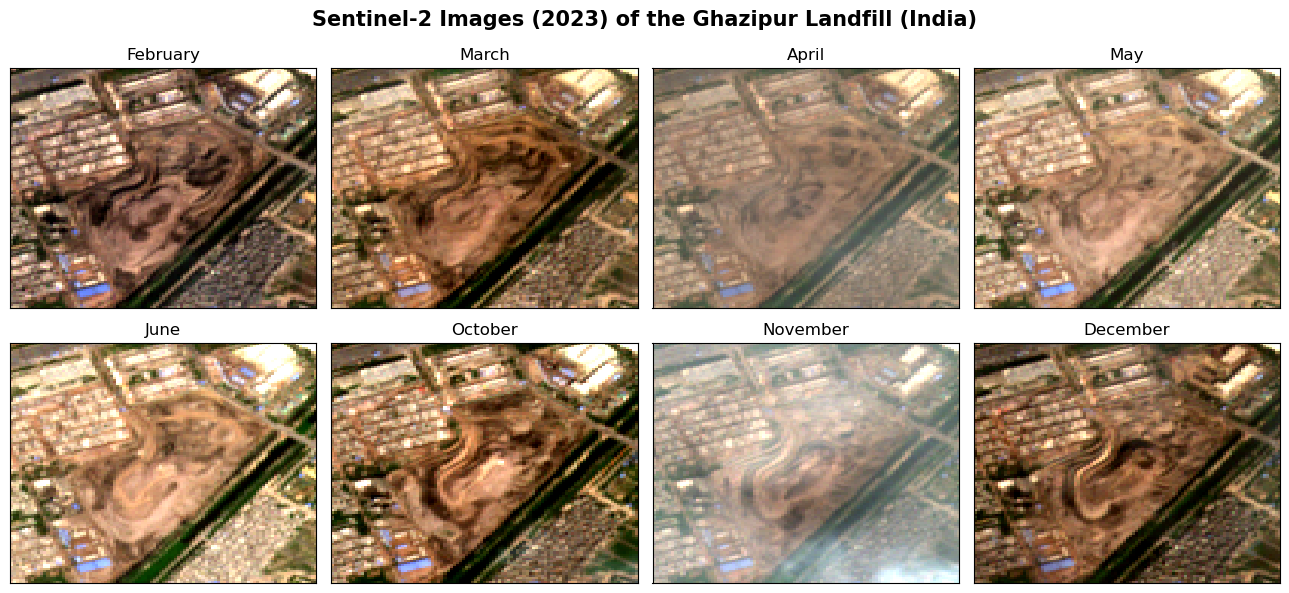

In [10]:
g = rgb_Ghazipur['rgb'].plot.imshow(x="x", y="y", col="month", col_wrap=4, robust=True, rasterized=True)

for i, ax in enumerate(g.axs.flat):
    ax.set_title(calendar.month_name[rgb_Ghazipur['rgb'].month[i].item()])
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

plt.suptitle('Sentinel-2 Images (2023) of the Ghazipur Landfill (India)')
plt.tight_layout()
plt.savefig('../figures/S2_tseries_Ghazipur.pdf')